## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Dataset

In [2]:
df = pd.read_csv("Social_Network_Ads.csv")

In [3]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
User ID            400 non-null int64
Gender             400 non-null object
Age                400 non-null float64
EstimatedSalary    400 non-null float64
Purchased          400 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 15.8+ KB


In [5]:
X = df.iloc[:, 2:-1]
y = df.iloc[:, -1]

## Building model pipeline

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [7]:
model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("kernel_pca", KernelPCA(n_components=2, kernel="rbf")),
    ("logreg", LogisticRegression(C=1.0, random_state=0))
])

In [8]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kernel_pca',
                 KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3,
                           eigen_solver='auto', fit_inverse_transform=False,
                           gamma=None, kernel='rbf', kernel_params=None,
                           max_iter=None, n_components=2, n_jobs=None,
                           random_state=None, remove_zero_eig=False, tol=0)),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                      

In [9]:
accuracies = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)
print(f"Accuracy for eack fold:\n{accuracies}")

Accuracy for eack fold:
[0.83333333 0.9        0.76666667 0.93333333 0.8        0.83333333
 0.9        0.9        1.         0.93333333]


In [10]:
MEAN = accuracies.mean()
STD = accuracies.std(ddof=1)
t = stats.t.ppf(0.975, df=9)

min_bound = np.round(MEAN-t*STD/np.sqrt(10), 3)
max_bound = np.round(MEAN+t*STD/np.sqrt(10), 3)

print(f"With 95% confidence, the true accuracy is found in the interval {(min_bound, max_bound)}")

With 95% confidence, the true accuracy is found in the interval (0.829, 0.931)


In [11]:
y_pred = model.predict(X_test)

##### Model Evaluation

In [12]:
accuracies = cross_val_score(model, X_test, y_test, scoring="accuracy", cv=10)
print(f"Accuracy for eack fold:\n{accuracies}")

Accuracy for eack fold:
[0.9 0.8 1.  1.  0.8 0.8 0.9 0.9 0.8 0.9]


In [13]:
MEAN = accuracies.mean()
STD = accuracies.std(ddof=1)
t = stats.t.ppf(0.975, df=9)

min_bound = np.round(MEAN-t*STD/np.sqrt(10), 3)
max_bound = np.round(MEAN+t*STD/np.sqrt(10), 3)

print(f"With 95% confidence, the true accuracy is found in the interval {(min_bound, max_bound)}")

With 95% confidence, the true accuracy is found in the interval (0.824, 0.936)


+ Classification Report

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93        68
           1       0.87      0.81      0.84        32

    accuracy                           0.90       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.90      0.90      0.90       100



+ Confusion Matrix

In [15]:
y_predicted = pd.DataFrame(data=y_pred, index=y_test.index, columns=["Predicted"])
complete = pd.merge(left=y_test, right=y_predicted, right_index=True, left_index=True)

complete["Purchased"] = complete["Purchased"].apply(lambda x: "Yes" if x==1 else "No")
complete["Predicted"] = complete["Predicted"].apply(lambda x: "Yes" if x==1 else "No")

conf_matrix = complete.groupby(["Purchased", "Predicted"]).size().unstack("Predicted")
conf_matrix

Predicted,No,Yes
Purchased,,
No,64,4
Yes,6,26


+ Decision Boundaries

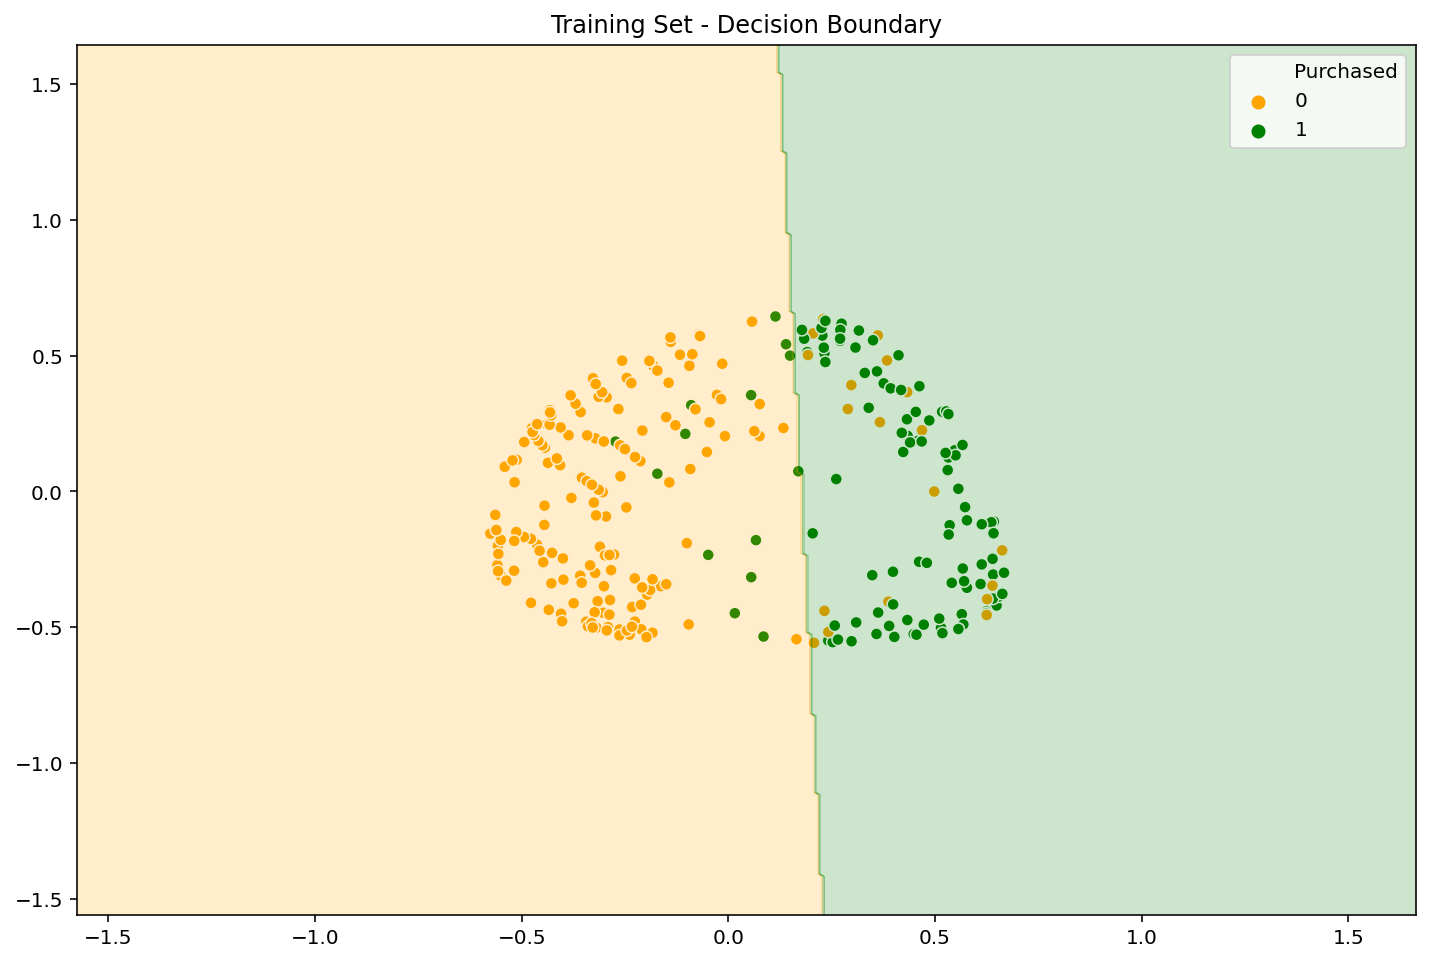

In [16]:
from matplotlib.colors import ListedColormap

X_pca = model[:2].transform(X_train)

fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.scatterplot(X_pca[:,0], X_pca[:,1], 
                    hue=y_train, palette=["orange", "green"], ax=ax)
xx, yy = np.mgrid[X_pca[:,0].min()-1:X_pca[:,0].max()+1:0.01,
                  X_pca[:,1].min()-1:X_pca[:,1].max()+1:0.01]
grid = np.c_[xx.ravel(), yy.ravel()]
classes = model[-1].predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, classes, cmap=ListedColormap(("orange", "green")), alpha=0.2)
ax.set_title("Training Set - Decision Boundary")
plt.show()

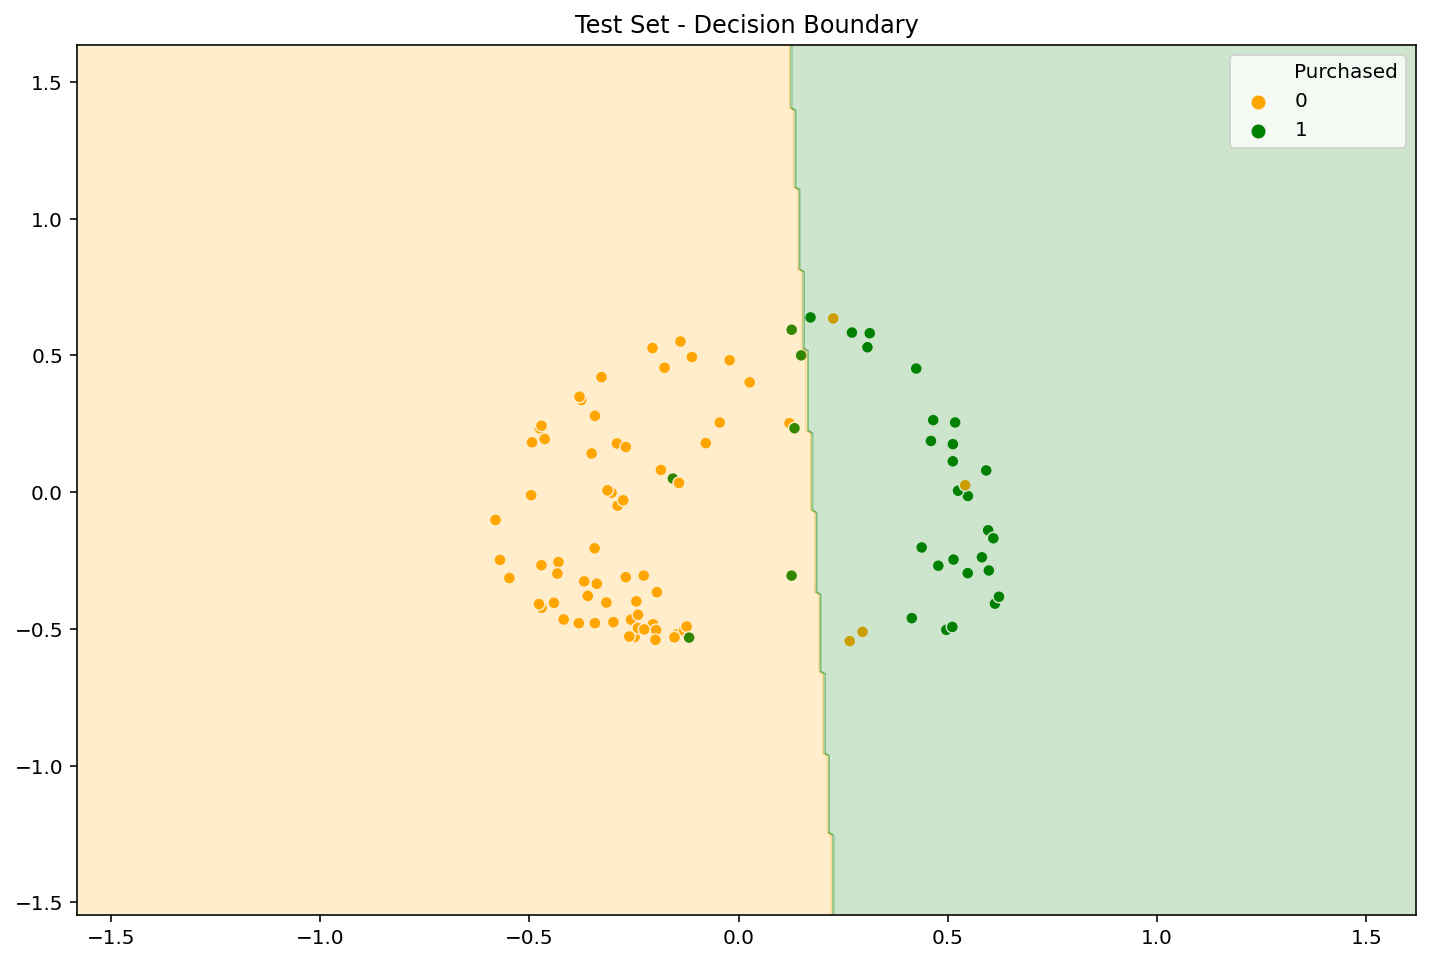

In [17]:
from matplotlib.colors import ListedColormap

X_pca = model[:2].transform(X_test)

fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.scatterplot(X_pca[:,0], X_pca[:,1], 
                    hue=y_test, palette=["orange", "green"], ax=ax)
xx, yy = np.mgrid[X_pca[:,0].min()-1:X_pca[:,0].max()+1:0.01,
                  X_pca[:,1].min()-1:X_pca[:,1].max()+1:0.01]
grid = np.c_[xx.ravel(), yy.ravel()]
classes = model[-1].predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, classes, cmap=ListedColormap(("orange", "green")), alpha=0.2)
ax.set_title("Test Set - Decision Boundary")
plt.show()